In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlxtend.data as mld
import warnings as w
w.filterwarnings('ignore')
import glob
import pickle

In [2]:
train_data,train_label = mld.loadlocal_mnist(images_path='../../DataSets/MNIST/train-images-mnist.idx3-ubyte', # extract zip file
                        labels_path='../../DataSets/MNIST/train-labels-mnist.idx1-ubyte')

test_data,test_label = mld.loadlocal_mnist(images_path='../../DataSets/MNIST/test-images-mnist.idx3-ubyte', # extract zip file
                        labels_path='../../DataSets/MNIST/test-labels-mnist.idx1-ubyte')


In [3]:
train_data = train_data/train_data.max()
test_data = test_data/test_data.max()

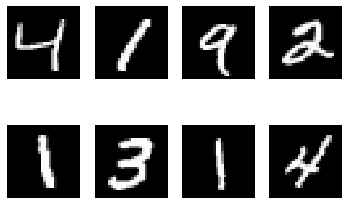

In [4]:
for i in range(1,9):
    plt.subplot(240+i)
    plt.axis('off')
    plt.imshow(train_data[1+i,:].reshape(28,28), cmap='gray')
plt.show()

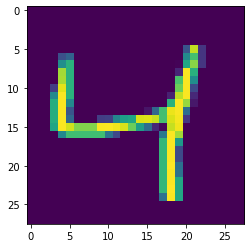

In [5]:
plt.imshow(train_data[2,:].reshape(28,28))

In [6]:
len(np.unique(train_label))

10

In [7]:
class NeuralNetwork():
    
    def __init__(self):
        
        self.layers_n       = []
        self.theta_layers   = []
        self.bias           = []
        self.activation_func= []
        self.activations    = []
        self.dL_dA          = []
        self.dL_dtheta      = []
        self.dL_dbias       = []
        self.itera          = []
        self.csfun          = []
                
    def add(self , neuron , activation_function = 'relu'):
        '''You have to give the no. of neurons you want to given layer.
            First layer neurons = no. of columns of your data
            
            default activation function is 'relu' you can change to 'sigmoid' , 'softmax' also
        '''
        self.layers_n.append(neuron)
        
        if activation_function == 'sigmoid' or activation_function == 'relu' or activation_function == 'softmax':
            self.activation_func.append(activation_function)
        else:
            raise TypeError('Pass only relu or sigmoid , and softmax for last layer')
    
    def one_hot_label(self , y):
        one_hot_labels = np.zeros((y.shape[0] , self.layers_n[-1]))
        for i in range(y.shape[0]):  
            one_hot_labels[i, y[i] ] = 1
        return one_hot_labels

    
    def fit(self , X , y , batch_size = 128 , alpha = 0.01 , epoche = 100,lmda = .01):
        for i in range(len(self.layers_n)-1): 
            self.theta_layers.append(np.random.randn(self.layers_n[i],self.layers_n[i+1]))
            
            self.bias.append((np.random.randn(self.layers_n[i+1])))
        
        return self.gradientDecent( X , y , batch_size , alpha , epoche )
    
    def softmax(self , activation , theta , bias):
        exp = np.exp( np.dot( activation , theta ) + bias)
        denominator = np.sum( exp , axis = 1)
        s = list(map(lambda i : exp[:,i] / denominator , np.arange(self.layers_n[-1])))
        return np.array(s).T
    
    def relu(self,activation,theta, bias):
        q = (np.dot(activation , theta) + bias)
        return np.clip(q , a_min=0 , a_max = q)
    
    def sigmoid(self, activation , theta , bias):
        return  1 / (1 + np.exp(np.dot(activation , theta) +  bias))
    
    def forwardPropagation(self,X):
        
        self.activations    = []
        self.activations.append(X)
        
        for i in range(len(self.layers_n)-2):
            self.activations.append(self.relu(self.activations[i] , self.theta_layers[i] , self.bias[i])) 
                      
        self.activations.append(self.softmax(self.activations[-1] , self.theta_layers[-1] , self.bias[-1]))
        
    def costFunction(self,X,y):
        
        self.y = self.one_hot_label(y)
        self.forwardPropagation(X)
        
        np.nan_to_num(self.activations[-1] , copy = False)
        self.crossEntropy = self.y * np.log(self.activations[-1])
        np.nan_to_num(self.crossEntropy, copy=False)
        
        #regu = self.lmda * (np.sum(self.theta_layer1)**2 + np.sum(self.theta_layer2)**2 + np.sum(self.theta_layer3)**2 + np.sum(self.theta_layer4)**2)
        return (1/X.shape[0] * -np.sum(self.crossEntropy)) #+ regu  # regu = 0 bcz lmda is zero 
      
    
    def costFunctionDerivative(self,X,y,alpha):
        
        self.dL_dA          = []
        self.dL_dtheta      = []
        self.dL_dbias       = []
        
        self.forwardPropagation(X)
        
        self.y_cap = self.activations[-1]
        self.target_y = self.one_hot_label(y)
        self.dL_dA.append(self.y_cap - self.target_y)
        
        for i in range(len(self.layers_n)-2):   
            
            self.dL_dA.append( np.dot( self.dL_dA[i] , self.theta_layers[-1-i].T ) )
        
        for i in range(len(self.layers_n)-1):  
            
            # Storing derivative in a list
            self.dL_dtheta.append(1/X.shape[0] * (np.dot(self.activations[-2-i].T , self.dL_dA[i]))) 
            self.dL_dbias.append(1/X.shape[0] * self.dL_dA[i])
        
        for i in range(len(self.layers_n)-1):  
            
            # updating parameters
            self.theta_layers[i]    -= (alpha * self.dL_dtheta[-1-i])  
            self.bias[-1-i]         -= (alpha * self.dL_dbias[i].sum(axis = 0))                  
            
            # dont get confuse by [-1-i] . Actually derivative are calculated during backpropagation
            # and original values are initialized during forward propagation so derivative are stored in
            # reverse order while data's stored in forward order
      
    def gradientDecent(self , X , y , batch , alpha , epoche  ):
        i = 1
        while i < epoche:
            
            index = np.random.randint(0 , X.shape[0] , size=(batch,))
        
            initial_cost = self.costFunction(X[index] , y[index] )
       
            self.costFunctionDerivative(X[index], y[index],alpha )
        
            print('Iteration {} Cost function {}'.format(i , initial_cost ))    
        
            self.itera.append(i)
            self.csfun.append(initial_cost)
            i+=1
            
        final_cost = self.costFunction(X[index] , y[index] )
        self.itera.append(i)
        self.csfun.append(final_cost)
            
        
            
    def gradient_plot(self):
        plt.plot(self.itera[10:],self.csfun[10:])
         
        
    def accuracy(self , X , y):
        self.forwardPropagation(X)
        pred = np.argmax(self.activations[-1],axis=1)
        c1 = 0
        for i,j in enumerate(y):
            if j == pred[i]:
                c1+=1
        print("Accuracy : ",(c1/y.shape[0])*100,'%')
        
    def predict(self,X):
        self.forwardPropagation(X)
        return np.argmax(self.activations[-1],axis = 1)
    
    def predict_prob(self,X):
        self.forwardPropagation(X)
        return self.activations[-1]
        


In [16]:
NN = NeuralNetwork()
NN.add(784)
NN.add(200)
NN.add(10)
NN.fit(train_data,train_label,alpha=0.099,epoche = 3500,batch_size = 2000)

Iteration 1 Cost function inf
Iteration 2 Cost function inf
Iteration 3 Cost function inf
Iteration 4 Cost function 101.58574857424634
Iteration 5 Cost function 76.00648656063991
Iteration 6 Cost function 54.5231822682551
Iteration 7 Cost function 41.90447023839092
Iteration 8 Cost function 31.724943397786724
Iteration 9 Cost function 26.682851894602013
Iteration 10 Cost function 23.903867790566373
Iteration 11 Cost function 23.09945119015483
Iteration 12 Cost function 21.89204088560185
Iteration 13 Cost function 19.590614588022586
Iteration 14 Cost function 19.62505662683726
Iteration 15 Cost function 21.360474523183367
Iteration 16 Cost function 16.410104030978157
Iteration 17 Cost function 16.29749793687255
Iteration 18 Cost function 15.746585474039856
Iteration 19 Cost function 16.833431209875915
Iteration 20 Cost function 15.768335878279023
Iteration 21 Cost function 14.42909364006896
Iteration 22 Cost function 14.629222784256031
Iteration 23 Cost function 13.687771013963095
Itera

Iteration 359 Cost function 3.6281072299395634
Iteration 360 Cost function 3.448371492276946
Iteration 361 Cost function 3.84305456776063
Iteration 362 Cost function 3.851535473461944
Iteration 363 Cost function 3.8660344716657673
Iteration 364 Cost function 3.949870986438875
Iteration 365 Cost function 3.765015600088095
Iteration 366 Cost function 3.7590312112657194
Iteration 367 Cost function 3.1106920162471776
Iteration 368 Cost function 3.853117694814732
Iteration 369 Cost function 3.7787408242707707
Iteration 370 Cost function 3.171779352656935
Iteration 371 Cost function 3.7372771896491486
Iteration 372 Cost function 4.2178269323915165
Iteration 373 Cost function 3.5840021482154336
Iteration 374 Cost function 3.953993298561845
Iteration 375 Cost function 3.9541060293589085
Iteration 376 Cost function 3.6364662248466963
Iteration 377 Cost function 3.164111750272208
Iteration 378 Cost function 3.779064435963615
Iteration 379 Cost function 3.8627600686052994
Iteration 380 Cost funct

Iteration 536 Cost function 2.651640547247915
Iteration 537 Cost function 3.196222151952421
Iteration 538 Cost function 3.030768857124445
Iteration 539 Cost function 2.5596172273486624
Iteration 540 Cost function 2.7940503150463436
Iteration 541 Cost function 2.2489076999271536
Iteration 542 Cost function 3.4814904049440094
Iteration 543 Cost function 2.869346426829447
Iteration 544 Cost function 2.612938224587281
Iteration 545 Cost function 3.0439958526755087
Iteration 546 Cost function 3.3835382281561817
Iteration 547 Cost function 3.3316936080801187
Iteration 548 Cost function 3.3514542143654014
Iteration 549 Cost function 2.9416273690042125
Iteration 550 Cost function 2.7545717800351253
Iteration 551 Cost function 3.250773259190026
Iteration 552 Cost function 2.7596244453617778
Iteration 553 Cost function 2.9653400251046236
Iteration 554 Cost function 3.435792680571212
Iteration 555 Cost function 2.9021548865771463
Iteration 556 Cost function 2.951079573394859
Iteration 557 Cost fu

Iteration 713 Cost function 2.318274433265374
Iteration 714 Cost function 2.3727488688418235
Iteration 715 Cost function 2.932214891952955
Iteration 716 Cost function 3.1361703312924876
Iteration 717 Cost function 2.984103420412091
Iteration 718 Cost function 2.1859695786080153
Iteration 719 Cost function 2.543003463087219
Iteration 720 Cost function 2.9916022915634906
Iteration 721 Cost function 2.4062763505702223
Iteration 722 Cost function 2.2943144268955336
Iteration 723 Cost function 2.466505968754983
Iteration 724 Cost function 2.5713932532256276
Iteration 725 Cost function 2.5723306308960643
Iteration 726 Cost function 1.8839337945465422
Iteration 727 Cost function 2.7667598851086064
Iteration 728 Cost function 2.843509341731214
Iteration 729 Cost function 2.5402568246296893
Iteration 730 Cost function 2.571821949542622
Iteration 731 Cost function 2.6540572468861336
Iteration 732 Cost function 2.7323093324985446
Iteration 733 Cost function 2.3789407246138072
Iteration 734 Cost f

Iteration 890 Cost function 2.1686487926115823
Iteration 891 Cost function 2.325388897521673
Iteration 892 Cost function 2.1053862046949026
Iteration 893 Cost function 2.0745633716891927
Iteration 894 Cost function 2.363898694304634
Iteration 895 Cost function 2.296192516986232
Iteration 896 Cost function 2.10017518735517
Iteration 897 Cost function 1.9513119971458974
Iteration 898 Cost function 2.3172348272723564
Iteration 899 Cost function 2.014971731292866
Iteration 900 Cost function 2.1864634003307852
Iteration 901 Cost function 1.868603917596105
Iteration 902 Cost function 2.0083602167270684
Iteration 903 Cost function 2.1558011396104244
Iteration 904 Cost function 2.4733385424912093
Iteration 905 Cost function 2.339506993751098
Iteration 906 Cost function 2.186383902086895
Iteration 907 Cost function 1.9505934913118703
Iteration 908 Cost function 2.140638365057919
Iteration 909 Cost function 2.3788215566167152
Iteration 910 Cost function 1.959079175558843
Iteration 911 Cost funct

Iteration 1066 Cost function 2.1994072182630147
Iteration 1067 Cost function 2.2535814737871944
Iteration 1068 Cost function 1.8918824270301111
Iteration 1069 Cost function 2.4575509060509466
Iteration 1070 Cost function 2.3064463091152128
Iteration 1071 Cost function 1.7568290469702488
Iteration 1072 Cost function 1.8645125791576325
Iteration 1073 Cost function 2.2186094455595087
Iteration 1074 Cost function 2.1255880962728457
Iteration 1075 Cost function 1.9253757530824744
Iteration 1076 Cost function 2.069527026782508
Iteration 1077 Cost function 2.242921514769546
Iteration 1078 Cost function 2.1005048477849235
Iteration 1079 Cost function 1.8742534565902274
Iteration 1080 Cost function 2.0076647817957096
Iteration 1081 Cost function 1.6390727453189033
Iteration 1082 Cost function 2.0707185757354876
Iteration 1083 Cost function 1.9349204767864703
Iteration 1084 Cost function 1.8786540995249836
Iteration 1085 Cost function 1.7051814702210104
Iteration 1086 Cost function 2.28956495824

Iteration 1238 Cost function 1.7133940812022754
Iteration 1239 Cost function 1.5256215715959085
Iteration 1240 Cost function 1.7640377702030468
Iteration 1241 Cost function 1.6615323727243403
Iteration 1242 Cost function 2.039626213661274
Iteration 1243 Cost function 1.539994336783397
Iteration 1244 Cost function 1.642773718434496
Iteration 1245 Cost function 2.1688144982048305
Iteration 1246 Cost function 1.706329930198238
Iteration 1247 Cost function 1.5666224862909455
Iteration 1248 Cost function 1.9803504311378415
Iteration 1249 Cost function 1.9182102253937734
Iteration 1250 Cost function 1.570144024719828
Iteration 1251 Cost function 1.6468946239249325
Iteration 1252 Cost function 1.8446649586685666
Iteration 1253 Cost function 1.408834756491876
Iteration 1254 Cost function 1.6388224257778659
Iteration 1255 Cost function 1.751720394370517
Iteration 1256 Cost function 1.8364500577897225
Iteration 1257 Cost function 1.675059581539203
Iteration 1258 Cost function 1.805262526099405
I

Iteration 1410 Cost function 1.8751358717303042
Iteration 1411 Cost function 1.4406813332328563
Iteration 1412 Cost function 1.3593942309108655
Iteration 1413 Cost function 1.3786009183790142
Iteration 1414 Cost function 1.5757111636132308
Iteration 1415 Cost function 1.6230513946202052
Iteration 1416 Cost function 1.5625717432036703
Iteration 1417 Cost function 1.4650883012085265
Iteration 1418 Cost function 1.3808480471698008
Iteration 1419 Cost function 1.355948158421878
Iteration 1420 Cost function 1.714073969179496
Iteration 1421 Cost function 1.484718058112799
Iteration 1422 Cost function 1.620376765818763
Iteration 1423 Cost function 1.5074797643483044
Iteration 1424 Cost function 1.8273229656739114
Iteration 1425 Cost function 1.8462098375111373
Iteration 1426 Cost function 1.3796875082634097
Iteration 1427 Cost function 1.4461198990808317
Iteration 1428 Cost function 1.7225836813289106
Iteration 1429 Cost function 1.9727872712345478
Iteration 1430 Cost function 1.5650274880630

Iteration 1583 Cost function 1.4438373215407583
Iteration 1584 Cost function 1.3976365564322104
Iteration 1585 Cost function 1.2146296718043308
Iteration 1586 Cost function 1.4592936421671776
Iteration 1587 Cost function 1.5430538762832104
Iteration 1588 Cost function 1.284884977970259
Iteration 1589 Cost function 1.2475507520287095
Iteration 1590 Cost function 1.4378843356058382
Iteration 1591 Cost function 1.157226261113656
Iteration 1592 Cost function 1.2763788198342634
Iteration 1593 Cost function 1.3870918654459128
Iteration 1594 Cost function 1.393924874456802
Iteration 1595 Cost function 1.6448182283072401
Iteration 1596 Cost function 1.7473341542607046
Iteration 1597 Cost function 1.4139123668511497
Iteration 1598 Cost function 1.5096470999911398
Iteration 1599 Cost function 1.3680256105890236
Iteration 1600 Cost function 1.5210478538397114
Iteration 1601 Cost function 1.5416971014979017
Iteration 1602 Cost function 1.4653885277131735
Iteration 1603 Cost function 1.733174718934

Iteration 1756 Cost function 1.345223836693153
Iteration 1757 Cost function 1.2591460058069492
Iteration 1758 Cost function 1.5198719707251571
Iteration 1759 Cost function 1.0457601019675076
Iteration 1760 Cost function 1.4366988918854757
Iteration 1761 Cost function 1.2565880650103314
Iteration 1762 Cost function 1.6752481881266228
Iteration 1763 Cost function 1.3911780023410416
Iteration 1764 Cost function 1.2776071924270727
Iteration 1765 Cost function 1.447626869259197
Iteration 1766 Cost function 1.0264495448585482
Iteration 1767 Cost function 1.196648497242648
Iteration 1768 Cost function 1.3082873652468339
Iteration 1769 Cost function 1.4600599802143024
Iteration 1770 Cost function 1.3879407949918123
Iteration 1771 Cost function 1.4688517988101184
Iteration 1772 Cost function 1.4577747332722981
Iteration 1773 Cost function 1.328101423878598
Iteration 1774 Cost function 1.2270247422402099
Iteration 1775 Cost function 1.1780941489396262
Iteration 1776 Cost function 1.4595273645591

Iteration 1929 Cost function 1.2859125356307293
Iteration 1930 Cost function 1.126010725961649
Iteration 1931 Cost function 1.082725567659851
Iteration 1932 Cost function 1.4565227140882318
Iteration 1933 Cost function 1.1326884454750061
Iteration 1934 Cost function 1.4699460971029263
Iteration 1935 Cost function 1.2290980365670086
Iteration 1936 Cost function 1.0356866152203708
Iteration 1937 Cost function 1.3002124139861189
Iteration 1938 Cost function 1.2328543618965915
Iteration 1939 Cost function 1.3019706712909103
Iteration 1940 Cost function 1.130875134922529
Iteration 1941 Cost function 1.2005185808797625
Iteration 1942 Cost function 1.1450201560239812
Iteration 1943 Cost function 1.2889205173201972
Iteration 1944 Cost function 1.431454695362556
Iteration 1945 Cost function 1.0979161251601668
Iteration 1946 Cost function 1.4167841572492013
Iteration 1947 Cost function 1.135318194271773
Iteration 1948 Cost function 1.229735499316595
Iteration 1949 Cost function 1.254170215496592

Iteration 2101 Cost function 1.27651257865123
Iteration 2102 Cost function 1.0119498955844466
Iteration 2103 Cost function 1.2642699532522204
Iteration 2104 Cost function 1.3373505140837492
Iteration 2105 Cost function 1.0982106839872052
Iteration 2106 Cost function 1.026246201709611
Iteration 2107 Cost function 1.0221570417630295
Iteration 2108 Cost function 1.0580299173329992
Iteration 2109 Cost function 1.1378496441118666
Iteration 2110 Cost function 1.2909170597030346
Iteration 2111 Cost function 0.8737265900335858
Iteration 2112 Cost function 0.8494343836690971
Iteration 2113 Cost function 1.0855739599542003
Iteration 2114 Cost function 1.1653807425836495
Iteration 2115 Cost function 1.1478892164967014
Iteration 2116 Cost function 1.2176070373895376
Iteration 2117 Cost function 1.082879402573629
Iteration 2118 Cost function 1.457978513485157
Iteration 2119 Cost function 1.1134423214338496
Iteration 2120 Cost function 1.1338421216909156
Iteration 2121 Cost function 1.13316841325115

Iteration 2273 Cost function 0.9769695199500632
Iteration 2274 Cost function 0.8492816365225772
Iteration 2275 Cost function 1.1119506806678179
Iteration 2276 Cost function 1.083654750232181
Iteration 2277 Cost function 1.1462085780676563
Iteration 2278 Cost function 0.9708014225721493
Iteration 2279 Cost function 0.9853527029908513
Iteration 2280 Cost function 0.8540548649453015
Iteration 2281 Cost function 0.9666639852446113
Iteration 2282 Cost function 0.8608929874530964
Iteration 2283 Cost function 0.9002992856270807
Iteration 2284 Cost function 0.895165331436124
Iteration 2285 Cost function 0.7825365342819348
Iteration 2286 Cost function 1.1209079123961239
Iteration 2287 Cost function 1.129886385965766
Iteration 2288 Cost function 0.8584736645440386
Iteration 2289 Cost function 0.8982979415051784
Iteration 2290 Cost function 1.0515628452707202
Iteration 2291 Cost function 1.0772977086411335
Iteration 2292 Cost function 1.2034628831215144
Iteration 2293 Cost function 1.071234943304

Iteration 2445 Cost function 1.0325806835512485
Iteration 2446 Cost function 0.9538190859759114
Iteration 2447 Cost function 0.7762588911173741
Iteration 2448 Cost function 0.89987337769521
Iteration 2449 Cost function 0.8651001150068447
Iteration 2450 Cost function 1.0996012091573348
Iteration 2451 Cost function 0.9807490390324439
Iteration 2452 Cost function 0.8800174995042827
Iteration 2453 Cost function 0.9439590515150594
Iteration 2454 Cost function 0.9808592465887312
Iteration 2455 Cost function 1.0484153480662435
Iteration 2456 Cost function 0.9474582397062882
Iteration 2457 Cost function 1.0570328461060976
Iteration 2458 Cost function 1.0797442288440267
Iteration 2459 Cost function 0.9426321849454391
Iteration 2460 Cost function 1.1179537747485155
Iteration 2461 Cost function 0.9380308952671713
Iteration 2462 Cost function 0.9156671055300508
Iteration 2463 Cost function 1.0060462218285495
Iteration 2464 Cost function 1.0651336042078374
Iteration 2465 Cost function 0.89893252916

Iteration 2618 Cost function 0.9086158219598778
Iteration 2619 Cost function 0.9147892679555762
Iteration 2620 Cost function 1.1764025596295438
Iteration 2621 Cost function 0.8053112240487786
Iteration 2622 Cost function 0.6849157023267824
Iteration 2623 Cost function 0.7188035368389187
Iteration 2624 Cost function 0.8208870977981427
Iteration 2625 Cost function 0.7061889301359834
Iteration 2626 Cost function 0.7767668675548917
Iteration 2627 Cost function 0.8413088366476794
Iteration 2628 Cost function 1.2093640306937428
Iteration 2629 Cost function 0.756571443203636
Iteration 2630 Cost function 0.8216963756943296
Iteration 2631 Cost function 1.0304990216786691
Iteration 2632 Cost function 0.9400844556423174
Iteration 2633 Cost function 0.8113011189976169
Iteration 2634 Cost function 0.8364170066043194
Iteration 2635 Cost function 0.8079396545493706
Iteration 2636 Cost function 1.0674985271347892
Iteration 2637 Cost function 0.9124327650482511
Iteration 2638 Cost function 0.8355948979

Iteration 2790 Cost function 0.6984677144452989
Iteration 2791 Cost function 0.9883097853557138
Iteration 2792 Cost function 0.9594828661612217
Iteration 2793 Cost function 0.8684338558304281
Iteration 2794 Cost function 0.9703823046234145
Iteration 2795 Cost function 0.8349552127660941
Iteration 2796 Cost function 0.7812801315471407
Iteration 2797 Cost function 0.9217172268005029
Iteration 2798 Cost function 0.8664908088504168
Iteration 2799 Cost function 0.8950536974647637
Iteration 2800 Cost function 0.9060132510708708
Iteration 2801 Cost function 0.7755233612918871
Iteration 2802 Cost function 0.6734871020534099
Iteration 2803 Cost function 0.8214618079454292
Iteration 2804 Cost function 0.8618872605186656
Iteration 2805 Cost function 0.9044309612786577
Iteration 2806 Cost function 0.9534263816018681
Iteration 2807 Cost function 0.7914719692596803
Iteration 2808 Cost function 0.7794152009212826
Iteration 2809 Cost function 0.7820526707201904
Iteration 2810 Cost function 0.895256209

Iteration 2962 Cost function 0.7692777814338673
Iteration 2963 Cost function 0.7603137252967298
Iteration 2964 Cost function 0.8214154131847884
Iteration 2965 Cost function 0.9076171046972065
Iteration 2966 Cost function 0.7392586219926854
Iteration 2967 Cost function 0.8846910894104383
Iteration 2968 Cost function 0.8680419785263049
Iteration 2969 Cost function 0.7814845963536851
Iteration 2970 Cost function 0.8110444804354925
Iteration 2971 Cost function 0.9599542133694261
Iteration 2972 Cost function 0.7422729336735597
Iteration 2973 Cost function 0.7003602935714935
Iteration 2974 Cost function 0.7135139677584995
Iteration 2975 Cost function 0.8881351948706376
Iteration 2976 Cost function 0.7378183767141026
Iteration 2977 Cost function 0.6707698686013284
Iteration 2978 Cost function 0.7631641944918766
Iteration 2979 Cost function 0.8595908495779322
Iteration 2980 Cost function 0.7638523483651162
Iteration 2981 Cost function 0.8655221629125357
Iteration 2982 Cost function 0.839750592

Iteration 3134 Cost function 0.932729959765448
Iteration 3135 Cost function 0.6599774581989911
Iteration 3136 Cost function 0.6678080366261948
Iteration 3137 Cost function 0.7227280910317415
Iteration 3138 Cost function 0.6854737542671674
Iteration 3139 Cost function 0.7705974296098387
Iteration 3140 Cost function 0.7212819167576486
Iteration 3141 Cost function 0.6749975834606203
Iteration 3142 Cost function 0.6958819992997738
Iteration 3143 Cost function 0.8690971606180621
Iteration 3144 Cost function 0.802482220789595
Iteration 3145 Cost function 1.0171248396553425
Iteration 3146 Cost function 0.9149754027392824
Iteration 3147 Cost function 0.799885604067944
Iteration 3148 Cost function 0.7702522216270902
Iteration 3149 Cost function 0.733965172648215
Iteration 3150 Cost function 0.7502752231594809
Iteration 3151 Cost function 0.8538425252911159
Iteration 3152 Cost function 0.7749066733534852
Iteration 3153 Cost function 0.610805294242343
Iteration 3154 Cost function 0.67264106326109

Iteration 3306 Cost function 0.6984974202062985
Iteration 3307 Cost function 0.7912759487253229
Iteration 3308 Cost function 0.6946377094041386
Iteration 3309 Cost function 0.690886095852237
Iteration 3310 Cost function 0.6145357361726562
Iteration 3311 Cost function 0.7613646279990568
Iteration 3312 Cost function 0.7560317523616894
Iteration 3313 Cost function 0.7678103882162494
Iteration 3314 Cost function 0.7211898441628264
Iteration 3315 Cost function 0.6018168793740799
Iteration 3316 Cost function 0.6530388653279972
Iteration 3317 Cost function 0.7762615084345437
Iteration 3318 Cost function 0.6102385774051658
Iteration 3319 Cost function 0.6480936209323783
Iteration 3320 Cost function 0.8538695941728076
Iteration 3321 Cost function 0.7552217443654784
Iteration 3322 Cost function 0.7293168982221705
Iteration 3323 Cost function 0.8421658659316832
Iteration 3324 Cost function 0.678104008299439
Iteration 3325 Cost function 0.5377434907302884
Iteration 3326 Cost function 0.76271890359

Iteration 3479 Cost function 0.57140810000316
Iteration 3480 Cost function 0.7268996251736265
Iteration 3481 Cost function 0.49679313658283464
Iteration 3482 Cost function 0.7914314154055218
Iteration 3483 Cost function 0.695185662354638
Iteration 3484 Cost function 0.7774276154865016
Iteration 3485 Cost function 0.6687881925380094
Iteration 3486 Cost function 0.7565799117388995
Iteration 3487 Cost function 0.6882931185463877
Iteration 3488 Cost function 0.5960315147828573
Iteration 3489 Cost function 0.7040205220767322
Iteration 3490 Cost function 0.6629226284520685
Iteration 3491 Cost function 0.7067651098744594
Iteration 3492 Cost function 0.6662597492076967
Iteration 3493 Cost function 0.8618449411595865
Iteration 3494 Cost function 0.6421239719495565
Iteration 3495 Cost function 0.7926875150985867
Iteration 3496 Cost function 0.6064964250280197
Iteration 3497 Cost function 0.7419669946263479
Iteration 3498 Cost function 0.6174538013387096
Iteration 3499 Cost function 0.83517595770

Iteration 3650 Cost function 0.5926375441156689
Iteration 3651 Cost function 0.5222489261729547
Iteration 3652 Cost function 0.5356675864759785
Iteration 3653 Cost function 0.7044258084081612
Iteration 3654 Cost function 0.6739533697735028
Iteration 3655 Cost function 0.6211545243545838
Iteration 3656 Cost function 0.7581973772090387
Iteration 3657 Cost function 0.6945698923131974
Iteration 3658 Cost function 0.5329818454814019
Iteration 3659 Cost function 0.816781589759194
Iteration 3660 Cost function 0.6071749079319749
Iteration 3661 Cost function 0.7921795034849826
Iteration 3662 Cost function 0.7649651690818178
Iteration 3663 Cost function 0.5774584410610665
Iteration 3664 Cost function 0.6198701014766341
Iteration 3665 Cost function 0.6224960067216241
Iteration 3666 Cost function 0.661607730109232
Iteration 3667 Cost function 0.6761552946720915
Iteration 3668 Cost function 0.6920335627910484
Iteration 3669 Cost function 0.5744871839142262
Iteration 3670 Cost function 0.67062811365

Iteration 3822 Cost function 0.7426650663661684
Iteration 3823 Cost function 0.5441256486487835
Iteration 3824 Cost function 0.4857995550750997
Iteration 3825 Cost function 0.664604681793159
Iteration 3826 Cost function 0.49665498144610787
Iteration 3827 Cost function 0.5460411185465062
Iteration 3828 Cost function 0.6240868551902234
Iteration 3829 Cost function 0.6587199400910738
Iteration 3830 Cost function 0.6555381469434681
Iteration 3831 Cost function 0.6465123737890729
Iteration 3832 Cost function 0.7003515968573323
Iteration 3833 Cost function 0.6696609937314038
Iteration 3834 Cost function 0.7154445434571299
Iteration 3835 Cost function 0.7380416070553631
Iteration 3836 Cost function 0.46305710942384914
Iteration 3837 Cost function 0.6473989912768549
Iteration 3838 Cost function 0.7072605732468481
Iteration 3839 Cost function 0.6075157439299009
Iteration 3840 Cost function 0.648325430014977
Iteration 3841 Cost function 0.7022564422708595
Iteration 3842 Cost function 0.621205081

Iteration 3993 Cost function 0.8022773350961006
Iteration 3994 Cost function 0.6269513982905582
Iteration 3995 Cost function 0.5905529288369133
Iteration 3996 Cost function 0.5911468440776966
Iteration 3997 Cost function 0.45489438845017216
Iteration 3998 Cost function 0.6031360962171916
Iteration 3999 Cost function 0.7047259990681808
Iteration 4000 Cost function 0.5064126671719784
Iteration 4001 Cost function 0.49812361221255275
Iteration 4002 Cost function 0.4145181484500611
Iteration 4003 Cost function 0.47472036351182756
Iteration 4004 Cost function 0.608604125183899
Iteration 4005 Cost function 0.532399016805975
Iteration 4006 Cost function 0.5493712536527833
Iteration 4007 Cost function 0.5796784127231477
Iteration 4008 Cost function 0.5873098908745334
Iteration 4009 Cost function 0.6675391692750621
Iteration 4010 Cost function 0.9105523943092769
Iteration 4011 Cost function 0.6912903422909777
Iteration 4012 Cost function 0.5057034160598458
Iteration 4013 Cost function 0.54804573

Iteration 4164 Cost function 0.5537255095960246
Iteration 4165 Cost function 0.562981030771024
Iteration 4166 Cost function 0.5838038032619572
Iteration 4167 Cost function 0.6826681204012702
Iteration 4168 Cost function 0.7260239994886745
Iteration 4169 Cost function 0.8777830231876717
Iteration 4170 Cost function 1.1599758127796944
Iteration 4171 Cost function 2.2454055168057754
Iteration 4172 Cost function 2.1623694853898328
Iteration 4173 Cost function 4.142821790056536
Iteration 4174 Cost function 2.7147406564709744
Iteration 4175 Cost function 1.5090718308164754
Iteration 4176 Cost function 1.4953333169221743
Iteration 4177 Cost function 0.8181583780773569
Iteration 4178 Cost function 0.8260011141992566
Iteration 4179 Cost function 0.7772123167066193
Iteration 4180 Cost function 0.46186033530374665
Iteration 4181 Cost function 0.5645784614223827
Iteration 4182 Cost function 0.5735539898853953
Iteration 4183 Cost function 0.6862207566137569
Iteration 4184 Cost function 0.5671428843

Iteration 4335 Cost function 0.5092242047620097
Iteration 4336 Cost function 0.5142212689089167
Iteration 4337 Cost function 0.6405879209960132
Iteration 4338 Cost function 0.5990561092755033
Iteration 4339 Cost function 0.3810760149050054
Iteration 4340 Cost function 0.4940156771394308
Iteration 4341 Cost function 0.5618773000570396
Iteration 4342 Cost function 0.5332060792817491
Iteration 4343 Cost function 0.5487480459767583
Iteration 4344 Cost function 0.5095167232099109
Iteration 4345 Cost function 0.5096982973772112
Iteration 4346 Cost function 0.5629085930409445
Iteration 4347 Cost function 0.5847309300978489
Iteration 4348 Cost function 0.600675795970376
Iteration 4349 Cost function 0.5256164045344451
Iteration 4350 Cost function 0.7240294716093053
Iteration 4351 Cost function 0.5499217515381927
Iteration 4352 Cost function 0.6334647455198542
Iteration 4353 Cost function 0.5089986032415148
Iteration 4354 Cost function 0.5305514702372275
Iteration 4355 Cost function 0.5455913194

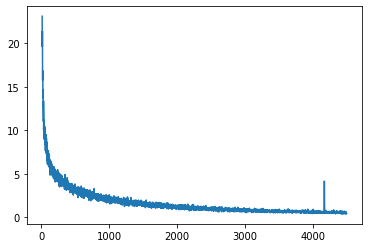

In [9]:
NN.gradient_plot()

In [10]:
NN.accuracy(test_data,test_label)
NN.accuracy(train_data,train_label)

Accuracy :  91.46 %
Accuracy :  92.48666666666666 %


# Lets look close what we find in first hidden layer network

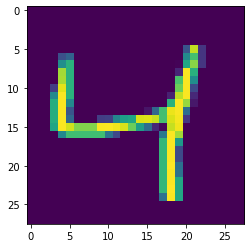

In [19]:
plt.imshow(train_data[2,:].reshape(28,28))

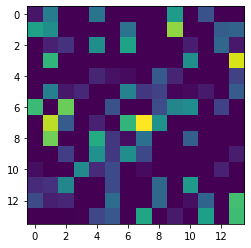

In [20]:
plt.imshow(NN.activations[1][2,:196].reshape(14,14))

# We trained our previous model with 200 neurons it's very small size of image if we resize them 
# Now i will pass 0,1,2 digits without shuffle with 1000 images 

In [ ]:
inde5 = np.hstack(np.argwhere(train_label == 0))[:1000]
inde4 = np.hstack(np.argwhere(train_label == 1))[:1000]
inde3 = np.hstack(np.argwhere(train_label == 2))[:1000]

q = np.append(inde5,[inde4,inde3])

In [ ]:
NN.accuracy(train_data[q],train_label[q])

In [ ]:
import pylab as pl
import scipy.stats as s
from IPython import display
import time

for i in range(1,3000,30):
    f = plt.figure()    
    f.add_subplot(1,2, 1)
    plt.axis('off')
    plt.imshow(train_data[q][i,:].reshape(28,28), cmap='gray')
    f.add_subplot(1,2, 2)
    plt.axis('off')
    plt.imshow(NN.activations[-2][i,:196].reshape(14,14), cmap='gray')
    display.clear_output(wait=True)
    display.display(pl.gcf())
    f.clear()

In [11]:
#with open('../../DataSets/Objects/ANN_mnist_scratch.pkl', 'wb') as output:
 #   pickle.dump(NN, output, pickle.HIGHEST_PROTOCOL)
with open('../../DataSets/Objects/ANN_mnist_scratch.pkl', 'rb') as inpt:
    NN = pickle.load(inpt)


# Explaining Kullback leibler divergence

In [14]:
# we have two distrubtions
NN.activations[-1].shape

(60000, 10)

In [22]:
np.argwhere(train_label==1)
np.argwhere(train_label==2)

array([[    5],
       [   16],
       [   25],
       ...,
       [59983],
       [59985],
       [59991]], dtype=int64)

In [25]:
import collections as c

In [27]:
counting = c.Counter(train_label) # dictionary